# Recombining trees algorithm

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import root
from time import time

In [ ]:
def standardNormalGaussianDensity(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-.5*np.power(x,2))

def d1(St, K, T, t, r, q, sigma):

    res = (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

    return res

def d2(St, K, T, t, r, q, sigma):

    res = (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

    return res

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2

def BSMdigitalCall(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

def BSMput(St, K, T, t, r, q, sigma):
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1

def BSMdigitalPut(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

In [ ]:
def BSMcallDelta(St, K, T, t, r, q, sigma):
    _d1 = d1(St, K, T, t, r, q, sigma)
    return np.exp(-q*(T-t))*sp.special.ndtr(_d1)

def BSMputDelta(St, K, T, t, r, q, sigma):
    _d1 = d1(St, K, T, t, r, q, sigma)
    return -np.exp(-q*(T-t))*sp.special.ndtr(-_d1)


# Binomial Tree Method

In [ ]:
class BinomialTree:
    def __init__(self, S0, T, r, q, sigma, noSteps):
        self.r = r
        self.q = q
        self.T = T
        self.noSteps = noSteps
        self.dt = T/(noSteps - 1)
        self.drift = (r-q-sigma**2/2)*self.dt
        self.randomInc = sigma*np.sqrt(self.dt)
        self.left = self.drift - self.randomInc
        self.right = self.drift + self.randomInc
        self.layers = [np.zeros(i+1) for i in range(noSteps)]
        self.layers[0][0] = S0

        self.split()

    def split(self):

        for i in range(1, self.noSteps):

            self.layers[i][0] = self.layers[i-1][0]*np.exp(self.left)

            for j in range(1,i+1):

                parentVal = self.layers[i-1][j-1]

                self.layers[i][j] = parentVal*np.exp(self.right)

    def evaluateOption(self, optionPayoff):
        prevLayer = optionPayoff(self.layers[-1])
        currLayer = np.zeros(prevLayer.size - 1)

        while currLayer.size > 0:

            for j in range(currLayer.size):
                currLayer[j] = np.exp(-self.r*self.dt)*(prevLayer[j] + prevLayer[j+1])/2

            prevLayer = currLayer
            currLayer = np.zeros(prevLayer.size - 1)

        return prevLayer[0]

    def evaluateAmericanPut(self, K):

        prevLayer = np.maximum(K - self.layers[-1],0)
        currLayer = np.zeros(prevLayer.size - 1)

        while currLayer.size > 0:

            for j in range(currLayer.size):
                currLayer[j] = np.maximum(np.exp(-self.r*self.dt)*(prevLayer[j] + prevLayer[j+1])/2, K-self.layers[currLayer.size][j])

            prevLayer = currLayer
            currLayer = np.zeros(prevLayer.size - 1)

        return prevLayer[0]

In [ ]:
def checkAmericanPutConvergence(K):
    _array = np.zeros(maxPower - minPower)
    for idx,_power in enumerate(range(minPower,maxPower)):
        noSteps = 2**_power
        sT = BinomialTree(S0, T, r, q, sigma, noSteps)
        _array[idx] = sT.evaluateAmericanPut(K)

    print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, sigma = {sigma :.2f}')
    print(f'The American Put price is {_array[idx]:.3f} at {stepsArray[idx]/T} steps/year simulated')
    fig,ax = plt.subplots(1,1)
    ax.plot(stepsArray,_array)
    ax.set_xlabel(r'No of steps')
    ax.set_ylabel('American Put Option Price')
    ax.set_title('Binomial Tree American Put Option Approximation vs Number of Steps')

# Replication method

In [ ]:
def putPayoff(St,K):
    return np.maximum(K-St,0)


Algorithm used is described here http://www.jaeckel.org/AmericanReplicationInThePresenceOfUserDefinedSmileDynamics.pdf

In [ ]:
class AmericanPutOption:

    def __init__(self, n_steps, S0, K, T, r, q , sigma):

        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.n_steps = n_steps
        self.dt = T/(n_steps-1)
        self.boundaryX = np.zeros(n_steps)
        self.notionals = np.zeros(n_steps)

    def portfolio(self, newBoundaryPoint, t):

        # O_n is the value of the European put with expiry at t_n = T
        O_n = BSMput(St = newBoundaryPoint, K = self.K, T = self.T, t = t, r= self.r, q = self.q, sigma = self.sigma)
        _portfolioVal = O_n

        i = round(t/self.dt)

        for idx in np.flip(np.arange(i,n_steps-1)):

            if( self.boundaryX[idx] > 1e-5 and abs(self.notionals[idx]) > 1e-5):

                O_idx = BSMput(St = newBoundaryPoint, K = self.boundaryX[idx], T = (idx+1)*self.dt, t = t, r= self.r, q = self.q, sigma = self.sigma)
                _portfolioVal += self.notionals[idx]*O_idx

        return _portfolioVal

    def portfolioDelta(self, newBoundaryPoint, t):

        # Compute the delta of the current portfolio
        O_n_delta = BSMputDelta(newBoundaryPoint, self.K, self.T, t, self.r, self.q, self.sigma)
        _portfolioDelta = O_n_delta

        i = round(t/self.dt)

        for idx in np.flip(np.arange(i,n_steps-1)):

            if( self.boundaryX[idx] > 1e-5 and abs(self.notionals[idx]) > 1e-5):
                O_idx_delta = BSMputDelta(St = newBoundaryPoint , K = self.boundaryX[idx], T = (idx+1)*self.dt, t = t, r= self.r, q = self.q, sigma = self.sigma)
                _portfolioDelta += self.notionals[idx]*O_idx_delta

        return _portfolioDelta


    def evaluate(self):

        for i in np.flip(np.arange(n_steps-1)):

            real_t = i*self.dt
            fun = lambda x : self.portfolio(x, real_t)- K + x

            # Find the boundary between exercise and non-exercise regions
            # Apply root finding algorithm onto the Put function
            X = root(fun, x0 = S0).x[0]
            self.boundaryX[i] = X

            # Compute the delta of the current portfolio
            delta = self.portfolioDelta(X, real_t)
            self.notionals[i] = 1 + delta

        return self.portfolio(S0, 0)



In [ ]:
t = 0
T = 2
K = 100
S0 = 100
q = 0.0
sigma = .1
r = .05
epsilon = 1e-6
minPower = 5
maxPower = 11
stepsArray = np.power(2,np.arange(minPower, maxPower))

# Binomial Tree method

Using parameters: r = 0.05, q = 0.00, t = 0.00 years, T = 2.00 years, S0 = 100.00, K = 100.00, sigma = 0.10
The American Put price is 3.045 at 512.0 steps/year simulated


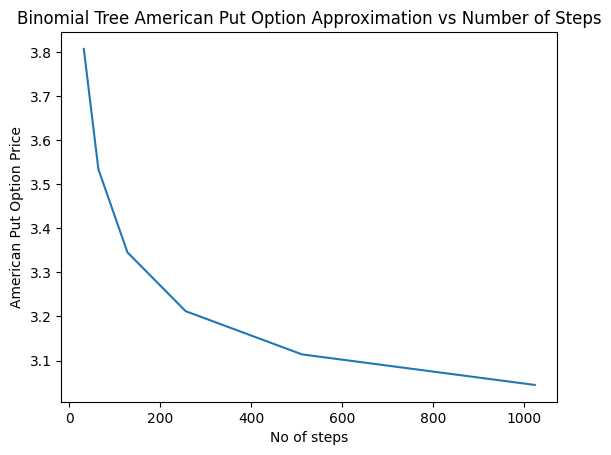

In [ ]:
checkAmericanPutConvergence(K)

In [ ]:
n_steps = 100
amOption = AmericanPutOption(n_steps, S0, K, T, r, q, sigma)

In [ ]:
_AmericanPutSim = amOption.evaluate()

In [ ]:
_AmericanPutRef = 2.86 # Obtained using online calculators
d = (_AmericanPutSim - _AmericanPutRef)/_AmericanPutRef
print(f'The discrepancy of Portfolio Replication American Put to asymptotic price is {d*100:.2f} %')

The discrepancy of Portfolio Replication American Put to asymptotic price is 0.81 %
